In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import re


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM , RNN , Dense , Flatten , Embedding , Bidirectional , Dropout , GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report , f1_score
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

In [69]:
import tensorflow.compat.v1 as tf 

tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 

print(tf.add([1.0, 2.0], [3.0, 4.0])) 

tf.Tensor([4. 6.], shape=(2,), dtype=float32)


In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
print('First 10 rows of training set')
train_df.head(10)

First 10 rows of training set


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [4]:
print('First 10 rows of test set')
test_df.head(10)

First 10 rows of test set


,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
5,000101884c19f3515c1a,How do you train a pigeon to send messages?
6,00010f62537781f44a47,What is the currency in Langkawi?
7,00012afbd27452239059,"What is the future for Pandora, can the busine..."
8,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
9,000156468431f09b3cae,How much does a tutor earn in Bangalore?


In [5]:
train_df.shape

(1306122, 3)

In [6]:
test_df.shape

(375806, 2)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            375806 non-null  object
 1   question_text  375806 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


In [9]:
train_df.describe()

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


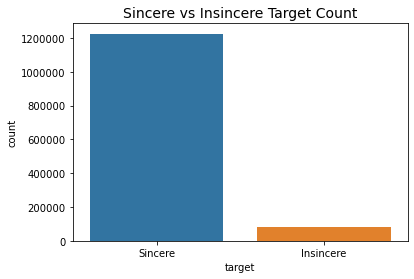

In [10]:
plt.figure()
sns.countplot(x="target", data=train_df)
plt.title("Sincere vs Insincere Target Count", fontsize=14)
plt.xticks([0,1],['Sincere','Insincere'])
plt.ticklabel_format(axis='y', style='plain')
plt.show()

In [11]:
train_df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Data is highly imbalanced

In [13]:
train_df.loc[train_df['qid']=='']

,qid,question_text,target


### Preprocessing

Create Vocab

In [14]:
def vocabulary(text):
    text = text.apply(lambda x: x.split()).values
    vocab = {}
    for sentences in text:
        for word in sentences:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab
            

In [15]:
vocab = vocabulary(train_df['question_text'])

In [16]:
# for key, value in vocab.items():
#    print(key, ' : ', value)

In [17]:
for k in list(vocab)[:30]:
    print({k:vocab[k]})

{'How': 261930}
{'did': 33489}
{'Quebec': 97}
{'nationalists': 91}
{'see': 9003}
{'their': 34810}
{'province': 124}
{'as': 55047}
{'a': 402682}
{'nation': 780}
{'in': 363131}
{'the': 653948}
{'1960s?': 56}
{'Do': 40041}
{'you': 186436}
{'have': 83239}
{'an': 66779}
{'adopted': 298}
{'dog,': 81}
{'how': 25842}
{'would': 51374}
{'encourage': 386}
{'people': 48317}
{'to': 403183}
{'adopt': 445}
{'and': 251973}
{'not': 41901}
{'shop?': 176}
{'Why': 142291}
{'does': 62725}


Load Embeddings

In [18]:
embeddings_index = {}
f = open('glove.840B.300d/glove.840B.300d.txt', encoding='utf8')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


Check the vocabulary which exists in the embeddings

In [19]:
def check_oov(vocab,embeddings):
    a={}
    oov={}
    k=0
    i=0
    
    for word in vocab:
        try:
            a[word] = embeddings[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_oov


In [20]:
oov = check_oov(vocab, embeddings_index)

Found embeddings for 33.16% of vocab
Found embeddings for  88.16% of all text


In [21]:
oov[:20]

[('India?', 16384),
 ('it?', 12900),
 ("What's", 12425),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386),
 ('people?', 4971),
 ('why?', 4943),
 ('Quora?', 4655),
 ('like?', 4487),
 ('for?', 4450),
 ('work?', 4206),
 ('2017?', 4050),
 ('mean?', 3971),
 ('2018?', 3594),
 ('country?', 3422)]

Try to incorporate the oov into the embedding vocab

In [22]:
def clean_text(vocab):
    
    vocab = str(vocab)
    for i in "?":
        vocab = vocab.replace(i,' ?')
    for i in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~‘' + '“”’' + '...':
        vocab = vocab.replace(i,' ')
    for i in '£है₹':
        vocab = vocab.replace(i,' ')
    for i in "  ":
        vocab = vocab.replace(i,' ')
    
    return vocab

#without the dictionary i'm getting 60% of the voabulary present in the embeddings.
#I will try to increase it by creating a dictionary for the misspelled words, acronyms, joined words and unknown words.


mispell_dict = {'Quorans':'Quora users',
                'cryptocurrencies':'cryptocurrency',
                'Brexit':'Britan exit',
                'Redmi':'phone company',
                'Quoras':'quora',
                '201718':'2017-2018',
                'Jongun':'Jong-un',
                'OnePlus':'phone company',
                'UCEED':'Undergraduate Common Entrance Examination for Design',
                'nonMuslims':'non-muslim',
                'nonMuslim':'non-muslim',
                'GDPR':'General Data Protection Regulation',
                'demonitisation':'demonetization',
                'Blockchain':'blockchain',
                'Coinbase':'cryptocurrency exchange company',
                'SJWs':'social justice warriors',
                'selfdriving':'self-driving',
                '20172018':'2017-2018',
                'BNBR':'Be Nice Be Respectful',
                'MUOET':'University online entrance test',
                'Boruto':'Japanese manga',
                'IIEST':'University',
                'ethereum':'bitcoin',
                'DCEU':'DC',
                'altright':'Alternative Right political ideology',
                'Qoura':'Quora',
                'UIUX':'UI UX',
                'BJPs':'BJP',
                'isare':'is are',
                'JongUn':'Jong-un',
                'AfricanAmericans':'African-Americans',
                'B1B2':'B1-B2',
                'LNMIIT':'university',
                'MHCET':'Common Entrance Test',
                'Upwork':'freelancing platform',
                'antiSemitic':'anti-Semitic',
                'etc   ':'etc',
                'iswas':'is was',
                'antiTrump':'anti Trump',
                'NICMAR':'university',
                'MHTCET':'Common Entrance Test',
                'DelhiNCR':'Delhi',
                'A2ad':'military strategy',
                '17yearold':'17 year old',
                'MyersBriggs':'Myers-Briggs',
                '201617':'2016-2017',
                'chsl':'conference',
                '13yearold':'13 year old',
                '14yearold':'14 year old',
                '201819':'2018-2019',
                'HackerRank':'educational website',
                'IIITH':'university',
                'nonEU':'non-EU',
                'eLitmus':'recruitment company',
                'selfstudy':'self-study',
                'Jiren':'fictional character',
                'Litecoin':'cryptocurrency',
                'altcoins':'cryptocurrency',
                'Cryptocurrency':'cryptocurrency',
                'bSC':'Bachelor of Science',
                '15yearold':'15 year old',
                'altcoin':'cryptocurrency',
                'Ryzen':'processor',
                'IsraelPalestine':'Israel Palestine',
                'SRMJEE':'entrance exam',
                'wasis':'was is',
                'nonEnglish':'non-English',
                'nonJews':'non-Jews',
                '16yearold':'16 year old',
                'coinbase':'cryptocurrency exchange company',
                '&amp':'ampersand',
                'Amazonin':'Amazon India',
                'Beerus':'fictional character',
                'SGSITS':'university',
                'IndoEuropean':'Indo-European',
                '12yearold':'12 year old',
                'dydx':'dydx',
                '20182019':'2018-2019',
                'Binance':'cryptocurrency exchange company',
                'Bschools':'Business Schools',
                'What\u200b':'What',
                'Zebpay':'cryptocurrency exchange company',
                'demonetisation':'demonetization',
                'Demonetization':'demonetization',
                'Zerodha':'stock exchange company',
                'Vajiram':'IAS coaching intitute',
                'Unacademy':'Online educational platform',
                'litecoin':'cryptocurrency',
                'etcand':'etc and',
                'Whst':'what',
                'examE':'exam',
                'etcin':'etc in',
                'brexit':'britan exit',
                'intitute':'institute'
               }  

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [37]:
train_df["question_text"] = train_df["question_text"].apply(lambda x: replace_typical_misspell(x))
train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_text(x))
vocab = vocabulary(train_df['question_text'])

test_df["question_text"] = test_df["question_text"].apply(lambda x: replace_typical_misspell(x))
test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_text(x))

In [24]:
oov = check_oov(vocab, embeddings_index)

Found embeddings for 74.24% of vocab
Found embeddings for  99.54% of all text


In [25]:
oov[:20]

[('Adityanath', 99),
 ('Machedo', 99),
 ('Kavalireddi', 65),
 ('etc…', 63),
 ('bhakts', 63),
 ('Doklam', 62),
 ('intitute', 59),
 ('AlShamsi', 52),
 ('Bhakts', 51),
 ('Awdhesh', 48),
 ('Baahubali', 44),
 ('x²', 42),
 ('Skripal', 40),
 ('bahubali', 38),
 ('BMSCE', 37),
 ('Ravula', 36),
 ('Alshamsi', 36),
 ('Gurugram', 36),
 ('josaa', 35),
 ('examE', 35)]

### Modelling

In [38]:
train, val = train_test_split(train_df, test_size=0.2, random_state=42)

X_train = train['question_text']
X_val = val['question_text']
X_test = test_df['question_text']

vocab_size = 50000
dimensions_size=300
max_length=100

#Initiate tokenizer
tokenizer = Tokenizer(num_words = vocab_size)

#getting list of train text and fitting tokenizer on texts
text = list(train_df['question_text'])
tokenizer.fit_on_texts(text)

#converting tokens of text into sequence of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

#adding padding to make length of texts uniform
X_train = pad_sequences(X_train, maxlen=max_length)
X_val = pad_sequences(X_val, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

y_train = train['target']
y_val = val['target']

In [39]:
len(tokenizer.word_index)

198619

In [41]:
#tokenizer.word_index.items()

In [50]:
#creating the embeddings vectors

def embedding_weights(vocab,embedding):  
    
    vocab_size = len(vocab)+1
    weight_matrix = np.zeros((vocab_size,300)) #each word with 300 dimensions
    
    for word , i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
            
    return(weight_matrix)


In [51]:
embedding_vectors = embedding_weights(tokenizer.word_index, embeddings_index)

In [52]:
embedding_vectors.shape

(198620, 300)

Bi-directional LSTM

In [59]:
embedding_layer = Embedding(len(tokenizer.word_index)+1,300,weights=[embedding_vectors])
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         59586000  
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        186880    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [63]:
checkpoint = ModelCheckpoint(
    filepath= 'model1.h5', 
    monitor = 'val_accuracy', 
    verbose = 1, 
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [64]:
hist=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=5,batch_size=512,callbacks=[checkpoint,reduce_lr])
for key in hist.history:
print(key)
model.save('./model2.h5')

Epoch 1/5
2041/2041 [==============================] - 5955s 3s/step - loss: 0.1168 - accuracy: 0.9551 - val_loss: 0.1000 - val_accuracy: 0.9603
Epoch 2/5
2041/2041 [==============================] - 5578s 3s/step - loss: 0.0953 - accuracy: 0.9622 - val_loss: 0.0985 - val_accuracy: 0.9609
Epoch 3/5
2041/2041 [==============================] - 5692s 3s/step - loss: 0.0824 - accuracy: 0.9673 - val_loss: 0.1027 - val_accuracy: 0.9599
Epoch 4/5
2041/2041 [==============================] - 5762s 3s/step - loss: 0.0680 - accuracy: 0.9728 - val_loss: 0.1146 - val_accuracy: 0.9571
Epoch 5/5
2041/2041 [==============================] - 5702s 3s/step - loss: 0.0537 - accuracy: 0.9785 - val_loss: 0.1352 - val_accuracy: 0.9554


In [65]:
pred_val = model.predict(X_val,batch_size=512,verbose=1).squeeze()

thresholds = []
for thresh in np.arange(0.1,0.501,0.01):
    thresh = np.round(thresh,2)
    res = metrics.f1_score(y_val, (pred_val > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))

511/511 [==============================] - 292s 569ms/step
**** F1 Score with 0.1 value ****  0.5937907175270701
**** F1 Score with 0.11 value ****  0.5977879932638478
**** F1 Score with 0.12 value ****  0.6017380881030866
**** F1 Score with 0.13 value ****  0.6054399552113465
**** F1 Score with 0.14 value ****  0.6090992625403483
**** F1 Score with 0.15 value ****  0.6120262807084365
**** F1 Score with 0.16 value ****  0.6147820654524485
**** F1 Score with 0.17 value ****  0.6166363966581911
**** F1 Score with 0.18 value ****  0.6193813023414801
**** F1 Score with 0.19 value ****  0.6217746700807564
**** F1 Score with 0.2 value ****  0.6238031453093218
**** F1 Score with 0.21 value ****  0.6257754652791675
**** F1 Score with 0.22 value ****  0.6275882916015919
**** F1 Score with 0.23 value ****  0.6292893401015228
**** F1 Score with 0.24 value ****  0.6312129269789324
**** F1 Score with 0.25 value ****  0.6333462083172396
**** F1 Score with 0.26 value ****  0.6353526712808151
**** F1 

In [66]:
preds_test = model.predict(X_test,batch_size=512,verbose=1).squeeze()

734/734 [==============================] - 405s 552ms/step


In [67]:
submission= pd.DataFrame({'qid':test_df['qid'],'prediction': preds_test})

In [70]:
submission.head(10)

,qid,prediction
0,0000163e3ea7c7a74cd7,7.167920e-01
1,00002bd4fb5d505b9161,4.425936e-07
2,00007756b4a147d2b0b3,4.272657e-07
3,000086e4b7e1c7146103,3.191435e-05
4,0000c4c3fbe8785a3090,7.052676e-02
5,000101884c19f3515c1a,2.274667e-03
6,00010f62537781f44a47,6.008278e-06
7,00012afbd27452239059,9.023086e-07
8,00014894849d00ba98a9,5.715189e-05
9,000156468431f09b3cae,3.270926e-05
